# Omnidirectional multi-view reconstruction

## Introduction

### Description

Depth map estimation for regular camera is a well studied topic in computer vision community. Many algorithms have been proposed in recent years, such as learning based mono depth estimation and multiview geometry based depth estimation. However, as these algorithms are based on regular camera model, depth estimation for omnidirectional camera is still a topic to be explored. 

The differences between regular cameras and omnidirectional cameras are shown in the Figure[?]. For a regular camera, the camera model can be simplified to a camera center plus an image plane. As long as the poses of cameras (from SfM or SLAM) and disparitise (from spares matching or dense matching) are estimated correctly, the depth map can be calculated easily. 

In comparison, for omnidirectional images (360 image), the "image plane" is a sphere. As a result, strong distortions are introduced by the projection from real scenes to the image sphere, leading to the failure of general sparse and dense matching algorithms. Since matching algorithms could not function correctly, disparity maps and the depth maps are relativelly difficult to be estimated. Besides, as the register operation introduces
more servere distortions[?], many classical algorithms are not applicable for 360 images. 

### Contribution

To solve the depth estimation problem for 360 images, here a cubic map based method is implemented. Since the main quesion is how to deal with the distortion caused the camera sphere, projecting a 360 image to its 6 tangent planes (6 cubic maps) is one of the most straght-forward way. The connections between 360 image and cubic maps are shown in Figure[?]. 

After cube projection, 360 images are decomposed to cubic maps, which can be treated as regular images. In addition, the camera parameters corresponding to these cubic maps can be easily obtained from original 360 images.  Thus, it is possible to use availabel algorithms to estimate depth map for each of these cubic maps. Then, with estimated cubic depth maps, a inverse projection from cubic maps to 360 images can generate the final 360 depth maps.In this project, the above cubic maps based method is implemented. Depth estimation for the cubic maps is based on the [colmap](https://colmap.github.io/), the patch matching stereo GPU part.

Besides, as 360 images contain rich information about a scene, in order to improve the quality of depth maps, a view selection method is implemented. Given a cubic map from the reference image, it computes the similarity as well as the triangulation angle between the reference cubic map and possible cubic projections of the source images. Therefore, the views for reconstruciton will be much better than those naive cubic maps.

After estimating all depth maps, as long as there are at least one 360 images having the corresponding depth map, new views at arbitrary poses can be synthesized. However, if only one source 360 image and depth map is used, the new view will have many invalid textures and holes. To improve the quality of the synthesized view, a multi-view synthesis method which considers the costs from depth estimation, the distance between 3d points and rays pointing from camera center to pixels as well as the distance between 3d points to the camera center is implemented.

This tutorial includes 4 parts:
1. a simple introduction of the provided cubemap class; 
2. an example for the wrapper of 360 depthmap estimation;
3. an example for the views selection and its performance;
4. an example for the view synthesis.

More details can be found in [this report]().

### Prerequisites

- [Ubuntu](http://releases.ubuntu.com/18.04/) or other Linux system, Mac. <br>
  As the installtions of some packages do not work well on Windows, this project is only tested on Ubuntu 18.04.
  

- To use cubemap functions, you have to install: <br>
  [numpy](https://www.numpy.org/), 
  [matplotlib](https://matplotlib.org/), 
  [scipy](https://www.scipy.org/), 
  [OpenCV](https://opencv.org), 
  [pyshtools](https://pypi.org/project/pyshtools/4.0/),
  [interpolation](https://pypi.org/project/interpolation/).
  

- To execute the wrapper correctly, a computer equiped with Nvidia GPUs (at least 4GB memory) with [CUDA](https://developer.nvidia.com/cuda-downloads) installed is necessary. It is recommended to execute the reconstruction on a server to avoid the 'timeout' error from GPU. Besides, you have to install [colmap](https://colmap.github.io/) or use the colmap in [this repository](https://github.com/GentleDell/Omni-stereo-dense-reconstruction/tree/master/PatchMatchStereo_GPU).

---

## Cubemap functions

#### Import packages

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from cam360 import Cam360
from cubicmaps import CubicMaps

#### Read image

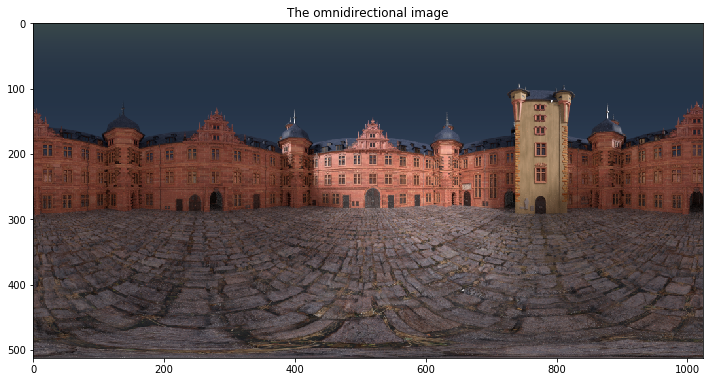

In [2]:
# path to the image
Image_path = '../data_demo/dataset/test_0_0_1_1024_5120000.png'

# the pose of the camera corresponding to the image
camera_pose = [np.eye(3), np.array([0, 0, 1])]

# read the image and make it in RGB order
Omni_img = np.flip(cv2.imread(Image_path), axis=2)   
Omni_img = Omni_img/np.max(Omni_img)

# show the loaded image
plt.figure(figsize=[12,8])
plt.imshow(Omni_img)
plt.title('The omnidirectional image');

Here the coordinate is defined as follow:
1. Right-hand coordinate is used here: x axis points to the right, y axis to the front and z axis to the sky.
2. "theta" is the angle between the z-axis and the ray pointing from the origin to the pixel on the camera sphere; Thus it is related to rows of a 360 image.
3. "phi" is the angle between the negative y axis and the plane formed by the pixel and z axis; thus it is related to columns of a 360 image. 
4. The range of columns (phi) of an 360 image is $[0, 2\pi]$ and the range of rows (theta) is $[0, \pi]$

Therefore, for an omnidirectional image as above, the textures from left to the right are: back(left side), left, front, right, back(right side)

#### Create a Cam360 object and then decompose it into 6 cubic maps

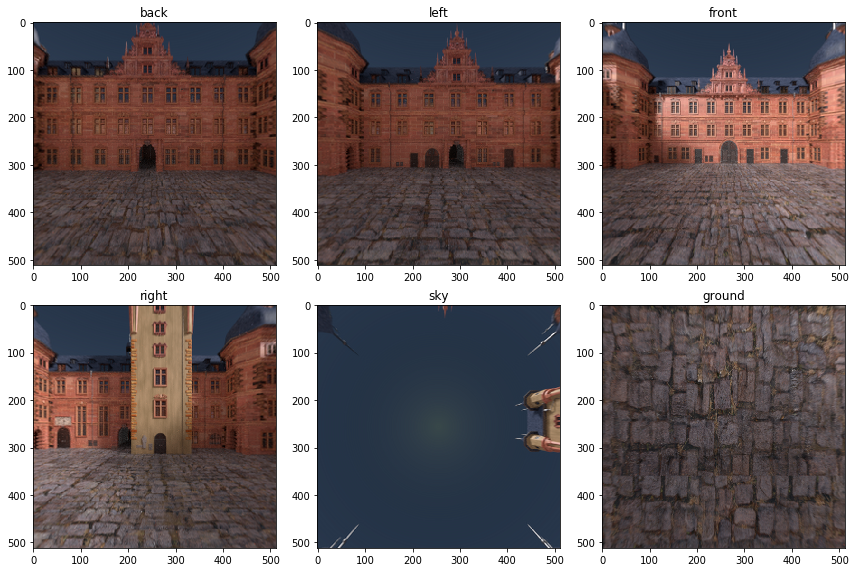

In [3]:
# generate a CubicMaps and a Cam360 object
cubemap_obj = CubicMaps()

Cam360_obj  = Cam360(rotation_mtx = camera_pose[0], 
                     translation_vec = camera_pose[1], 
                     height = Omni_img.shape[0], 
                     width  = Omni_img.shape[1], 
                     channels = Omni_img.shape[2], 
                     texture  = Omni_img)

# decompose the Cam360 object into 6 cubic maps with the specified resolution
# and the 6 cubic maps are stored at the obj.cubemap.
cubemap_obj.sphere2cube(Cam360_obj, resolution=[512, 512])

order = ['back', 'left', 'front', 'right', 'sky', 'ground']
plt.figure(figsize=[12,8])
for ct in range(len(cubemap_obj.cubemap)):
    plt.subplot(2,3,ct+1)
    plt.imshow(cubemap_obj.cubemap[ct])
    plt.title(order[ct])
    plt.tight_layout()

#### If a tangent plane at a given direction is required.

Here we assume that we want to project the 360 image to its tangent plane at $\phi = \pi$, $\theta = \pi/3$, with fov = $\pi/6$ for $\phi$ and $\theta$.

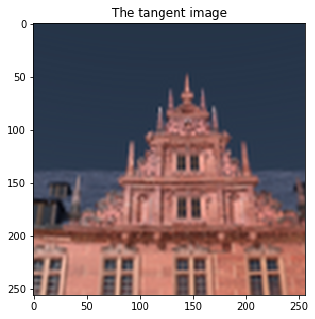

In [4]:
tangent = cubemap_obj.cube_projection(cam=Cam360_obj, 
                                      direction=(np.pi, np.pi/3, np.pi/6, np.pi/6),
                                      resolution=[256,256])


plt.figure(figsize=[10,5])
plt.imshow(tangent)
plt.title('The tangent image');

#### Merge 6 cubic maps to obtain a 360 image

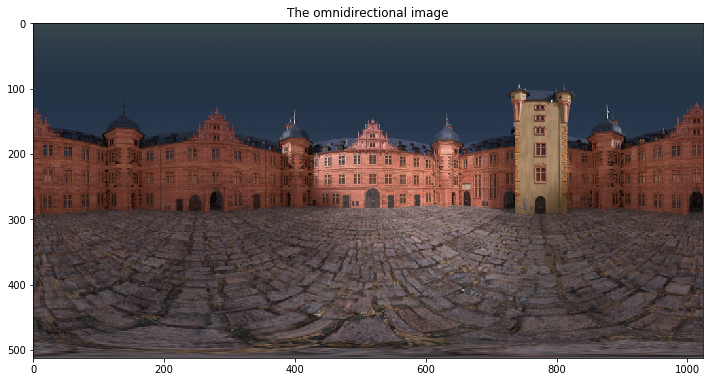

In [5]:
# use the function to covert cubic maps to 360 images, the result is stored at obj.omnimage
cubemap_obj.cube2sphere_fast(resolution=[512,1024])

# show the recovered omnidirectional image
plt.figure(figsize=[12,8])
plt.imshow(cubemap_obj.omnimage)
plt.title('The omnidirectional image');

## Depth estimation

The depth estimation is based on the patchmatch_stereo() integrated in [colmap](). To estimate depth maps for 360 images, two functions are provided:
1. giving a list of Cam360 objects;
2. giving the path to the image sets;

The later is based on the former with addition operations of loading images into a list of Cam360 objects.

#### 1. Giving a list of Cam360 objects

The **dense_from_cam360list()** in workspace_helper.py is for this function. Given a list of cam360 objects and some required parameters, it estimates corresponding depthmaps.

Firstly, it generates cubic maps for all objects. Then it collects cubic maps according to the view (back/front/laft/right) and saves diffetent views to corresponding folders (workspace/cubemaps/view0, workspace/cubemaps/view1, etc.). At the same time, it generates the camera models as well as the camera poses and save these data as .txt file to workspace/cubemaps/parameters/view* for patch matching stereo.

After preparation, it calls Patch Matching Stereo GPU module of colmap to work on cubic maps and then reorganize the estimated depth maps to /workspace/omni_depthmaps/image_name/.

Finally, it reproject the cubic depth maps back to the 360 camera to obtain omnidirectional depth maps.

In [6]:
import os
import glob
from workspace_helper import dense_from_cam360list

In [8]:
# define some path and necessary parameters
patchmatch_path = '../colmap'   # the colmap is just an example of outputing a string
workspace = '../data_demo/workspace'
path_to_image = "../data_demo/dataset/"

cam360_list = []
reference_image = 4
resolution = [512, 1024]

translations = np.array([[-4, -4, 1], [-4, 0, 1], [-4, 4, 1],
                        [ 0, -4, 1], [0, 0, 1] , [ 0, 4, 1],
                        [ 4, -4, 1], [4, 0, 1] , [ 4, 4, 1]])

# generate a cam360 list
for ind, filename in enumerate(sorted(glob.glob(os.path.join(path_to_image, '*.png')))):
    # load omnidirectional images
    Omni_img = np.flip(cv2.imread(filename), axis=2)   
    Omni_img = Omni_img/np.max(Omni_img)
    # create a Cam360 object
    Omni_obj = Cam360(rotation_mtx = np.eye(3), translation_vec=translations[ind], 
                     height = Omni_img.shape[0], width = Omni_img.shape[1], channels = Omni_img.shape[2], 
                     texture= Omni_img)
    cam360_list.append(Omni_obj)

    
cam360_list = dense_from_cam360list(cam360_list, 
                                   workspace = workspace,
                                   patchmatch_path = patchmatch_path, 
                                   reference_view  = reference_image,
                                   views_for_depth = 4,
                                   use_view_selection = False)

'''
    Out put will be like:

        Creating workspace: [====================] 100%

        Executing patch match stereo GPU
        
    As the colmap file is not the real colmap, the function will be stuck at
    'Executing patch match stereo GPU'.
    
    But we can check the folder: ./data_demo/workspace. There will be a dir
    named 'cubemaps' which contains 4 view* subdirctories and a 'parameters'
    dir with 4 view* subdirctories as well to store parameters for the colmap.
    
    It the correct path to colmap is specified, the 'patch_match_ws' will be 
    the workspace for colmap. The final omnidirectional depth map will be stored
    at ./data_demo/omni_depthmap/depth_maps together with corresponding cost maps
    in ./data_demo/omni_depthmap/cost_maps.
'''

#### 2. Giving the path to the image set

The **dense_reconstruct.py** realizes this function and can be run on the commandline directly. To use the script, python version should be 3.+ . The lastest release of python is prefered.

Usage:
python dense_reconstruct.py [-h] 
                            [--path_to_image]
                            [--patchmatch_path]
                            [--workspace]
                            [--reference_image]
                            [--views_for_synthesis]
                            [--use_colmap]
                            [--pose_list ...]
                            
optional arguments: <br>
  **-h, --help**        show this help message and exit;<br>
  **--path_to_image**   where the 360 imagses are stored; <br>
  **--patchmatch_path** Where is the exectable file of patch matching stereo GPU; <br>
  **--workspace**       Where to store the workspace; <br>
  **--reference_view**  The index of the reference view. Only works when view_selection is disabled;<br>
  **--view_selection**  Select views for dense reconstruction;<br>
  **--views_for_depth** The number of views to synthesize the 360 depthmap; only 4 and 6 are supported;<br>
  **--gpu_index**       The index of GPU to run the Patch Matching;<br>
  **--pose_list** [pose_list[pose_list [pose_list  ...]]] A list of pose corresponding to the images;<br>

## View selection

In order to leverage all information captured by 360 images to improve the quality of depth maps, a view selection method is implemented. 

For a given reference cubic map, it selects a view that satisfies two requirements. The first is that the reference cubic map and the source cubic map projected from the given 360 image should share the maximum overlapping. The second is that triangulation angle must be greater than a threshold. Otherwise, this source cubic map will have a low score. 

The reason for considering triangulation angles is that images sharing small viewpoint changes always have high texture similarity as long as the illumination changes are not very serious. However, those images are not good candidates for reconstruction as they do not have enough baseline for depth estimation. 

Here a simple example is provided to demonstrate the usage. The improvements of the quality of depth maps can be found in [this report](). 

In [9]:
from view_selection import view_selection

In [10]:
# obtain a reference view
cubemap_obj = CubicMaps()
reference   = cubemap_obj.sphere2cube(cam360_list[0], resolution=(256,256))[3]

# get the view without view selection 
original_view = cubemap_obj.sphere2cube(cam360_list[8], resolution=(256,256))[3]

# select view
selected_view, pose, score = view_selection(cam360_list[8], reference, initial_pose=(np.pi*3/2, np.pi/2))

the score of the selected view is: 2.0
the pose of the selected view is (phi = 5.08, theta = 1.52)


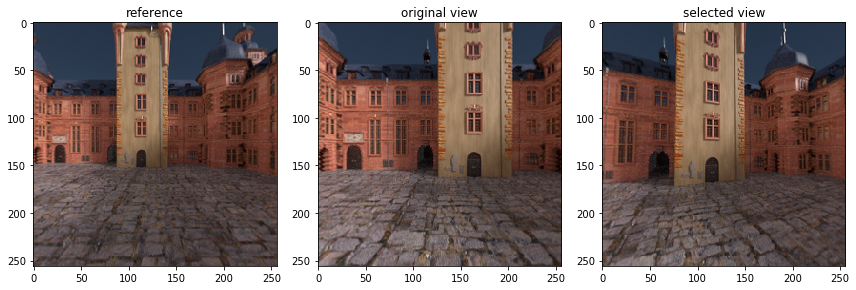

In [11]:
order = ['reference', 'original view', 'selected view']
image_list = [reference, original_view, selected_view]

plt.figure(figsize=[12,8])
for ct in range(len(image_list)):
    plt.subplot(2,3,ct+1)
    plt.imshow(image_list[ct])
    plt.title(order[ct])
    plt.tight_layout()

print('the score of the selected view is:', score)
print('the pose of the selected view is (phi = {:.2f}, theta = {:.2f})'.format(*pose))

The view selection function has been integrated into the dense_reconstruct() and dense_from_cam360list(). Setting the use_view_selection in dense_from_cam360list() to be True or setting --view_selection when execute dense_reconstruct.py will enable view selection.  

## View synthesis

After obtaining 360 depth maps, we can synthesize a new view. 

Firstly, all pixels of given views with valid depth are projected to the synthesis view according to the pose of the synthesis view and the source views. The simplest idea is to synthesize the view using one source view, which preserves the depth consistency. However, although using a single view preserves depth consistency, it leads to inconsistency on textures such as holes, especially when the synthesis view is far away from the source view. In this case, synthesizing view from multiple source views is better though it introduces noises in depth.

In order to filter out noises in depth map and make the texture and depth map as smooth as possible, the costs for all candidates of each pixel are computed and are used to sort the candidates. The costs are a weighted sum of three terms: the costs from depth estimation, the distance between 3d points and rays pointing from camera center to pixels as well as the distance between 3d points to the camera center. After sorting, there comes two choices: synthesizing view with the best candidates or conducting further filtering to achieve more consistent depth and texture. 

As the distortion of 360 images is very strong, filtering directly on depth space or texture space could make the view worse. Inspired by the fact that in general, it is more likely to have smooth texture if all pixels in a patch of the synthesis view are from the same source image, we implement filters on the indices space. Therefore, an index map is generated from the sorted candidates and filters such as median filter and total variation filter are tested on the indices space. Since the output indices of filtering could be wrong, e.g. the pixel is not observed by the view of the index, a post-process is necessary. For example, we can filter out the invalid indices by setting them to -1 (if the corresponding pixels are not observed by any one of the source views) or to replace these invalid indices with corresponding indices in the original indices map (if the pixels are observed at least once).  

To demonstrate the view synthesis, a pre-generated cam360 list is used. 9 views in total are used to generate the cam360_list. The 9 views are deployed in a sqare of length 4 and form a 3 by 3 matrix from [-4, -4] to [+4, +4]. The function takes 20 seconds for synthesizeing 512x1024 images. If gpu is enabled, then it will take 8 seconds. 

In [12]:
import pickle
import requests
from view_synthesis import synthesize_view

In [13]:
# output resolution and path to the pre-generated cam360 list
resolution = (512, 1024)
data = '../data_demo/intermediate_data_for_demo/cam360.pickle'
link = 'https://drive.google.com/file/d/1W5ZkClhlt_GfEYZDoK-NkAh37fgVjhwa/view?usp=sharing'

# if the file does not exist
if not os.path.isfile(data):
    raise ValueError("\nPlease download the file from this link:\n{:s} \nto \n{:s}". format(link, data))

# load the pickle file
pickle_in = open(data,"rb")
cam360_list = pickle.load(pickle_in)

method = 'sort'        # the method for filtering ['simple', 'sort', 'tv', 'median'] 
output_depth = True    # out put depth map or not

# pose of the synthesis view, have fun with it.
rotation = np.eye(3)
translation = np.array([-8,8,8])

**Firstly, we will show the result of using only one view for synthesis**

The source view here is the 4th view in the cam360_list, which is at [0,0,1]. It is obvious that both the texture and depth map are no smooth at all. Because the synthesis view is far away from the source view so that when there are some parts which are small in the original image become large in the synthesis view, there will be a lot of holes in those parts.

projecting pixels of original views to the synthesized view ...
>>>> projecting the 0 view ...
>>>> projecting the 1 view ...
>>>> projecting the 2 view ...
>>>> projecting the 3 view ...
>>>> projecting the 4 view ...
>>>> projecting the 5 view ...
>>>> projecting the 6 view ...
>>>> projecting the 7 view ...
>>>> projecting the 8 view ...
computing the cost and aggregating pixels ...
conducting optimization ...
generating texture ...


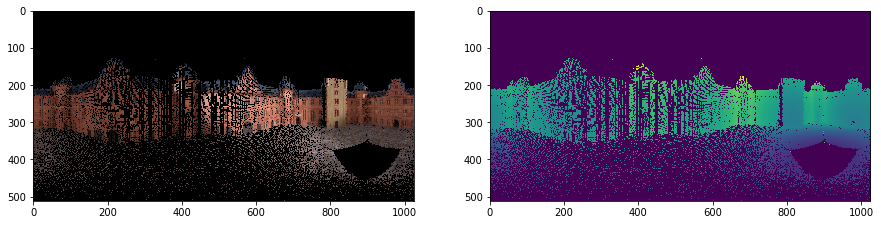

In [14]:
Syn_view, Syn_depth = synthesize_view(cam360_list, rotation, translation, 
                                      resolution, with_depth = output_depth, 
                                      method = 'simple', parameters = 4)

f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(Syn_view)
axarr[1].imshow(Syn_depth)

To show that the unconsistency is because the long distance between the source view and the synthesis view, we set the new synthesis view to be at [1,1,1] which is much closer than the formmer one. As shown in the figure below, the quality of the texture and depth become much better.

projecting pixels of original views to the synthesized view ...
>>>> projecting the 0 view ...
>>>> projecting the 1 view ...
>>>> projecting the 2 view ...
>>>> projecting the 3 view ...
>>>> projecting the 4 view ...
>>>> projecting the 5 view ...
>>>> projecting the 6 view ...
>>>> projecting the 7 view ...
>>>> projecting the 8 view ...
computing the cost and aggregating pixels ...
conducting optimization ...
generating texture ...


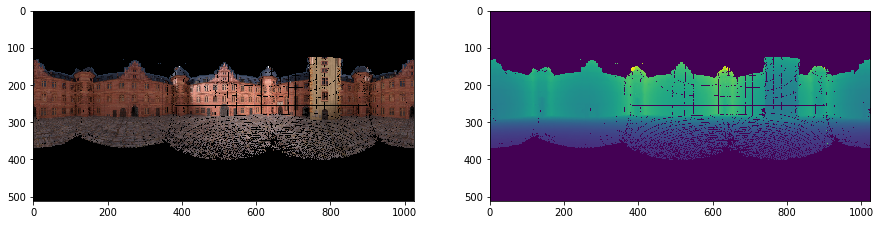

In [15]:
Syn_view, Syn_depth = synthesize_view(cam360_list, rotation, np.array([1,1,1]), 
                                      resolution, with_depth = output_depth, 
                                      method = 'simple', parameters = 4)

f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(Syn_view)
axarr[1].imshow(Syn_depth)

**Now we show the view synthesized with all 9 views**

The pose of the synthesis view is set back to [-8,8,8] and in this demo we use the **best candisates** of pixels to do the synthesis. Comparing to the one using only one view, using 9 views makes the texture more smooth and have less holes. However, although the depth map has less holes as well, there are a lot of noises, which means the smoothness on depth is not garanteed.

projecting pixels of original views to the synthesized view ...
>>>> projecting the 0 view ...
>>>> projecting the 1 view ...
>>>> projecting the 2 view ...
>>>> projecting the 3 view ...
>>>> projecting the 4 view ...
>>>> projecting the 5 view ...
>>>> projecting the 6 view ...
>>>> projecting the 7 view ...
>>>> projecting the 8 view ...
computing the cost and aggregating pixels ...
conducting optimization ...
generating texture ...


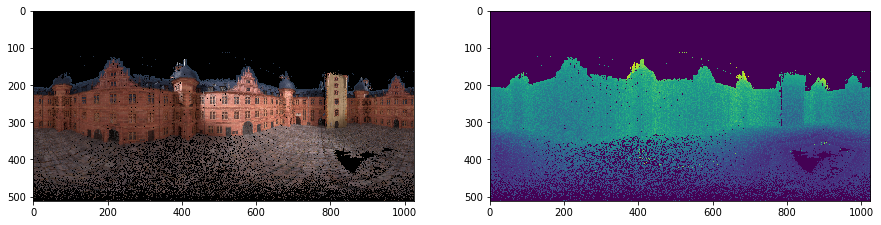

In [16]:
Syn_view, Syn_depth = synthesize_view(cam360_list, rotation, translation, 
                                      resolution, with_depth = output_depth, 
                                      method = 'sort', parameters = 4)

f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(Syn_view)
axarr[1].imshow(Syn_depth)

**The synthesis view with depth smoothness gueranteed (to some extent)**

Here median filter is used to filter outliers and to make the depth map become smooth. The reason for choosing median filter is that, the noises on dpeth map is similar to salt and pepper noise which is the case for median filter. It can be observed that, the depth map dose become more smooth while the smoothness of texture is kept as well. Total variant filter can do similar task but since it will 'generate' new candidate indices for pixels, it would be better to use median filter.

projecting pixels of original views to the synthesized view ...
>>>> projecting the 0 view ...
>>>> projecting the 1 view ...
>>>> projecting the 2 view ...
>>>> projecting the 3 view ...
>>>> projecting the 4 view ...
>>>> projecting the 5 view ...
>>>> projecting the 6 view ...
>>>> projecting the 7 view ...
>>>> projecting the 8 view ...
computing the cost and aggregating pixels ...
conducting optimization ...
generating texture ...


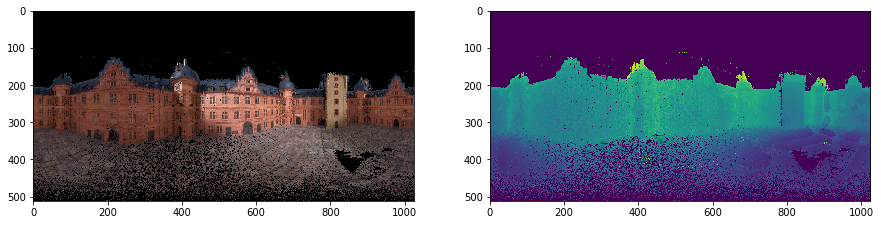

In [17]:
Syn_view, Syn_depth = synthesize_view(cam360_list, rotation, translation, 
                                      resolution, with_depth = output_depth, 
                                      method = 'median', parameters = 10)

f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(Syn_view)
axarr[1].imshow(Syn_depth)

---

## Summary

In this project, cubic maps are used for 360 image depth estimation. To improve the performance, a similarity and triangulation angle based view selection method is implemented. Finally, to synthesize smooth textures and depth map for any given pose, a view synthesis method is realized.

---